In [1]:
#%matplotlib inline
#data manip
import pandas as pd
import numpy as np

#data viz
#from matplotlib import pyplot as plt
#import seaborn as sns

#custom packages
import database_utility
import baseball_models

In [62]:
sqlite_file = 'baseball_data.sqlite'
dh = database_utility.DatabaseHelper(sqlite_file, 'baseball_key_joiner.csv')
#This will give a ValueError when using pd.read_json if the path doesn't exist
filepath = r'C:\Users\Chris\Google Drive\Programming\Baseball\Web Scraping\bbref_scraper\bbref_scraper\bbref.jl'

In [ ]:
batting_df, pitching_df = dh.load_data(preload=False, path2017="Web Scraping/bbref_scraper/bbref_scraper/bbref.jl", path2018="Web Scraping/bbref_2018.jl", write_csv=True, verbose=True)

<h4>Load Raw Data</h4>

The first step is to load in the raw data we want to use and trim it down to the appropriate timeframe we want

In [11]:
batting_df, pitching_df = dh.calc_fd_scores_roto()

Trying to load raw csvs!
CSV's Loaded!! Returning batting and pitching df
Loading rotoguru data..


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\IPython\core\interactiveshell.py:3209: DtypeWarning: Columns (14,15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Getting bbref key to merge rotoguru and bbref data
Gathering player lookup table. This may take a moment.
Cleaning up rotoguru dates..
Merging bbref and rotoguru data to get FD scores
Batting df pre merge:  (200411, 35)
Batting df post merge:  (174446, 37)
Pitching df pre merge:  (81140, 38)
Pitching df post merge:  (19284, 40)


<h4> Feature Engineering </h4> 

The next step is to create (or load) any features we want from the raw data

<h5> Create Features </h5>

In [5]:
batting_fe = baseball_models.FeatureEngineer(df=batting_df)
pitching_fe = baseball_models.FeatureEngineer(df=pitching_df)

In [6]:
%%time
pitch_life_avgs = pitching_fe.calc_lifetime_avg()
pitch_rolling_avgs = pitching_fe.calc_rolling_avg()
pitch_ytd_avgs = pitching_fe.calc_ytd_avgs()
pitch_rotoguru = pitching_fe.rotoguru_features(batting=False)

pitching_df['lagged_fd_score'] = pitching_df.sort_values(['player', 'game_date']).groupby(['player'])['FD_points'].shift(1)
pitch_lagged_fd = pitching_df[['roto_game_id', 'lagged_fd_score']]

C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (14,15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


Getting bbref key to merge rotoguru and bbref data
Gathering player lookup table. This may take a moment.
Cleaning up rotoguru dates..
Merging bbref and rotoguru data to get FD scores
Wall time: 3min 44s


In [15]:
%%time
bat_life_avgs = batting_fe.calc_lifetime_avg()
bat_rolling_avgs = batting_fe.calc_rolling_avg()
bat_ytd_avgs = batting_fe.calc_ytd_avgs()
bat_rotoguru = batting_fe.rotoguru_features()

batting_df['lagged_fd_score'] = batting_df.sort_values(['player', 'game_date']).groupby(['player'])['FD_points'].shift(1)
bat_lagged_fd = batting_df[['roto_game_id', 'lagged_fd_score']]
                            

C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\IPython\core\magic.py:187: DtypeWarning: Columns (14,15,45) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


Getting bbref key to merge rotoguru and bbref data
Gathering player lookup table. This may take a moment.
Cleaning up rotoguru dates..
Merging bbref and rotoguru data to get FD scores
Wall time: 5min 21s


In [16]:
bat_rotoguru.drop_duplicates(['roto_game_id'], inplace=True)

In [17]:
#THESE CALCS SHOULD GO IN A FILE
bat_start_pitcher_matchups = pd.read_csv("CSV/starting_pitcher_matchups_all.csv")

#we have to bring in the bbref key for joining later
batting_df_raw, pitching_df_raw = dh.load_data()
bat_start_pitcher_matchups = pd.merge(bat_start_pitcher_matchups, batting_df_raw[['game_id', 'player']], on='game_id')
bat_start_pitcher_matchups['roto_game_id'] = bat_start_pitcher_matchups['game_date'] + bat_start_pitcher_matchups['player']

#remove all where the batter id isnt there, we dont have matchup info for everyone
bat_start_pitcher_matchups[bat_start_pitcher_matchups['batter'] != 0].shape

bat_start_pitcher_matchups.drop(columns=['Unnamed: 0', 'batter', 'pitcher'], inplace=True)

#calculate some statistics from the raw data
bat_start_pitcher_matchups['ab'] = bat_start_pitcher_matchups.drop(['walk', 'hit_by_pitch', 'sac_fly', 'sac_fly_double_play', 'sac_bunt', 'sac_bunt_double_play', 'catcher_interf'], axis=1).sum(axis=1)

bat_start_pitcher_matchups['pa'] = bat_start_pitcher_matchups.sum(axis=1)

bat_start_pitcher_matchups['slugging_perc'] = (bat_start_pitcher_matchups['single'] + (2*bat_start_pitcher_matchups['double']) + \
                                            (3*bat_start_pitcher_matchups['triple']) + (4*bat_start_pitcher_matchups['home_run']))/ \
                                            bat_start_pitcher_matchups['ab']

bat_start_pitcher_matchups['hits'] = bat_start_pitcher_matchups['single'] + bat_start_pitcher_matchups['double'] + bat_start_pitcher_matchups['triple'] + bat_start_pitcher_matchups['home_run']
bat_start_pitcher_matchups['batting_avg'] = bat_start_pitcher_matchups['hits']/bat_start_pitcher_matchups['ab']

bat_start_pitcher_matchups['on_base_perc'] = (bat_start_pitcher_matchups['hits'] + bat_start_pitcher_matchups['walk'] + bat_start_pitcher_matchups['hit_by_pitch'])/bat_start_pitcher_matchups['pa']

#only keep these relevent statistics
bat_start_pitcher_matchups = bat_start_pitcher_matchups[['ab', 'pa', 'slugging_perc', 'hits', 'batting_avg', 'on_base_perc', 'roto_game_id']]

new_cols = []
for col in bat_start_pitcher_matchups.columns:
    if col != 'roto_game_id':
        new_cols.append(col + '_matchup_hist')
        
new_cols.append('roto_game_id')

bat_start_pitcher_matchups.columns = new_cols

bat_start_pitcher_matchups.fillna(0, inplace=True)
bat_start_pitcher_matchups.drop_duplicates(['roto_game_id'], inplace=True)

Trying to load raw csvs!
CSV's Loaded!! Returning batting and pitching df


Merge the features into one dataframe we can train the model on

In [9]:
pitch_feature_df = pd.merge(pitch_life_avgs, pitch_rolling_avgs, on='roto_game_id')
pitch_feature_df = pd.merge(pitch_feature_df, pitch_ytd_avgs, on='roto_game_id')
pitch_feature_df = pd.merge(pitch_feature_df, pitch_rotoguru, on='roto_game_id')
pitch_feature_df = pd.merge(pitch_feature_df, pitch_lagged_fd, on = 'roto_game_id')
pitch_feature_df = pd.merge(pitch_feature_df, pitching_df[['roto_game_id', 'FD_points']], on='roto_game_id')

In [18]:
#i think duplications are happening due to doubleheaders when the merges occur, hence the drop duplicates at the end
bat_feature_df = pd.merge(bat_life_avgs, bat_rolling_avgs, on='roto_game_id')
bat_feature_df = pd.merge(bat_feature_df, bat_ytd_avgs, on='roto_game_id')
bat_feature_df = pd.merge(bat_feature_df, bat_start_pitcher_matchups, on = 'roto_game_id', how='left')
bat_feature_df = pd.merge(bat_feature_df, bat_rotoguru, on='roto_game_id', how='left')
bat_feature_df = pd.merge(bat_feature_df, bat_lagged_fd, on = 'roto_game_id')
bat_feature_df = pd.merge(bat_feature_df, batting_df[['roto_game_id', 'FD_points']], on='roto_game_id')
bat_feature_df.drop_duplicates(['roto_game_id'], inplace=True)

In [19]:
#uncomment to write results to CSV to cache for the future
#pitch_feature_df.to_csv("CSV/pitch_feature_df.csv", index=False, header=True)
bat_feature_df.to_csv("CSV/bat_feature_df.csv", index=False, header=True)

LOAD FEATURES IF THEY EXIST ALREADY

In [14]:
#if they exist already and you just want to add new features - load them up here and then add new ones
#pitch_feature_df = pd.read_csv("CSV/pitch_feature_df.csv")
#bat_feature_df = pd.read_csv("CSV/bat_feature_df.csv")

#example of adding new features
#pitch_feature_df = pd.merge(pitch_feature_df, new_features, on='game_id')
#add in lagged fd score
pitch_feature_df = pd.merge(pitch_feature_df, pitch_lagged_fd, on='roto_game_id')
bat_feature_df = pd.merge(bat_feature_df, bat_lagged_fd, on = 'roto_game_id')

ADD IN PETE"S FEATURE CSV and mine - there is a na issue so joining pete's features to mine for now

In [ ]:
batting_df, pitching_df = dh.calc_fd_scores_roto()

In [181]:
pete_bat_feature_df = pd.read_csv('CSV/roto_frame_with_stadium.csv')
bat_feature_df = pd.read_csv("CSV/bat_feature_df.csv")

bat_feature_df = pd.merge(bat_feature_df, pete_bat_feature_df[['roto_game_id','home_run_ytdavg', 'double_ytdavg', 'batter_ytdavg', 'single_ytdavg', \
                                                              'stadium_BA', 'stadium_OBP', 'stadium_SLG', 'stadium_OPS', 'stadium_BAbip', 'fd_score']], on='roto_game_id')

#we need to remove test data!!!
bat_feature_df = pd.merge(bat_feature_df, batting_df[['roto_game_id', 'game_date', 'player']])

#Add in lagged FD score for testing to make sure I'm doing it right
bat_feature_df["fd_shift"] = bat_feature_df.sort_values(by=['player', 'roto_game_id']).groupby('player')['fd_score'].shift(1)
bat_feature_df.drop('player', axis=1, inplace=True)

bat_feature_df = bat_feature_df[(bat_feature_df['game_date'] > '2016-01-01') & (bat_feature_df['game_date'] < '2018-08-01')]

question - what is batter_ytdavg?

In [182]:
#col_to_keep = ['home_run_ytdavg', 'double_ytdavg', 'batter_ytdavg', 'single_ytdavg', 'PA_ytdavg', 'pitches_ytdavg', 'wpa_bat_pos_lifeavg', 'RBI_lifeavg', 'stadium_OBP', \
                #'stadium_SLG', 'stadium_BA', 'strikes_total_ytdavg', 'AB_ytdavg', 'stadium_BAbip', 'slugging_perc_matchup_hist', 'H/A_h', 'FD_points', 'roto_game_id']

col_to_keep = ['home_run_ytdavg', 'double_ytdavg', 'single_ytdavg', 'PA_ytdavg', 'pitches_ytdavg', 'wpa_bat_pos_lifeavg', 'RBI_lifeavg', \
                'strikes_total_ytdavg', 'AB_ytdavg', 'slugging_perc_matchup_hist', 'H/A_h', 'lagged_fd_score', 'stadium_BA', 'stadium_OBP', 'stadium_SLG', \
               'stadium_OPS', 'stadium_BAbip', 'FD_points', 'roto_game_id']

cols_to_keep = ['H/A_h', 'fd_score', 'fd_shift', 'roto_game_id']

bat_feature_df_sub = bat_feature_df[cols_to_keep]

Check how many NA's there are

In [183]:
bat_feature_df_sub.isna().sum().sort_values(ascending=False)

fd_shift        303
roto_game_id      0
fd_score          0
H/A_h             0
dtype: int64

<h4> Train the model </h4>

In [170]:
import xgboost
import baseball_models
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

Train the pitching model

In [13]:
pitching_cv = baseball_models.CrossValidator()

#make sure we are sorted by time (days)
pitch_feature_df.sort_values(by='roto_game_id',inplace=True)

X_pitch, y_pitch, tscv_pitch = pitching_cv.train_test_split(pitch_feature_df.drop('FD_points', axis=1), pitch_feature_df['FD_points'], num_splits=25)

#remove features that we know aren't valuable from previous feature engineering
#we can add new features that we are trying for the first time in the 'new_features parameter'
#life_features = pitch_life_avgs.drop('game_id', axis=1).columns

#add other new features here...

X_pitch = pitching_cv.clean_for_model(X_pitch, pitching=True)

#initialize the model
xgbreg_pitch = xgboost.XGBRegressor(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

pitching_cv.cross_validate(X_pitch, y_pitch, tscv_pitch, xgbreg_pitch)

Running iter: 1


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 1 took 7.503997802734375 seconds.
Running iter: 2


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 2 took 9.654002666473389 seconds.
Running iter: 3


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 3 took 13.081003904342651 seconds.
Running iter: 4


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 4 took 22.799001693725586 seconds.
Running iter: 5


C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Iter 5 took 21.098002910614014 seconds.


Train the batting model

In [5]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

For testing and looking at data

In [150]:
#are NAs causing us issues??
X_bat.dropna(inplace=True)

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

train_mae = []
test_mae = []

i=0
for train_index, test_index in tscv_bat.split(X_bat):
    if i < 300:
        start = time.time()
        print("Running iter: " + str(i+1))
        X_train, X_test = X_bat.iloc[train_index], X_bat.iloc[test_index]
        y_train, y_test = y_bat.iloc[train_index], y_bat.iloc[test_index]
        
        print("Train index len: " + str(len(X_train)))
        print("Test index len: " + str(len(X_test)))

        #remove the ids so we can link them back up to predictions later
        X_train_ids = X_train['roto_game_id']
        X_train = X_train.drop('roto_game_id', axis=1)
        
        #for seeing what we are predicting at each iter
        j=0
        for k in range(X_train.shape[0]):
            if j < 0:
                print(X_train.iloc[k], y_train.iloc[k])
                j+=1
        
        #train the model
        model = xgbreg_bat.fit(X_train, y_train)

        #same procedure - remove test ids
        X_test_ids = X_test['roto_game_id']
        X_test = X_test.drop('roto_game_id', axis=1)

        #run predictions using trained model
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        #record the results
        train_err = mean_absolute_error(y_train, train_preds)
        test_err = mean_absolute_error(y_test, test_preds)
        
        train_mae.append(train_err)
        test_mae.append(test_err)
        
        #print("Iter " + str(i) + " train err: " + str(train_err))
        #print("Iter " + str(i) + " test err: " + str(test_err))
        print("Iter " + str(i+1) + " took " + str(time.time()-start))
        i+=1



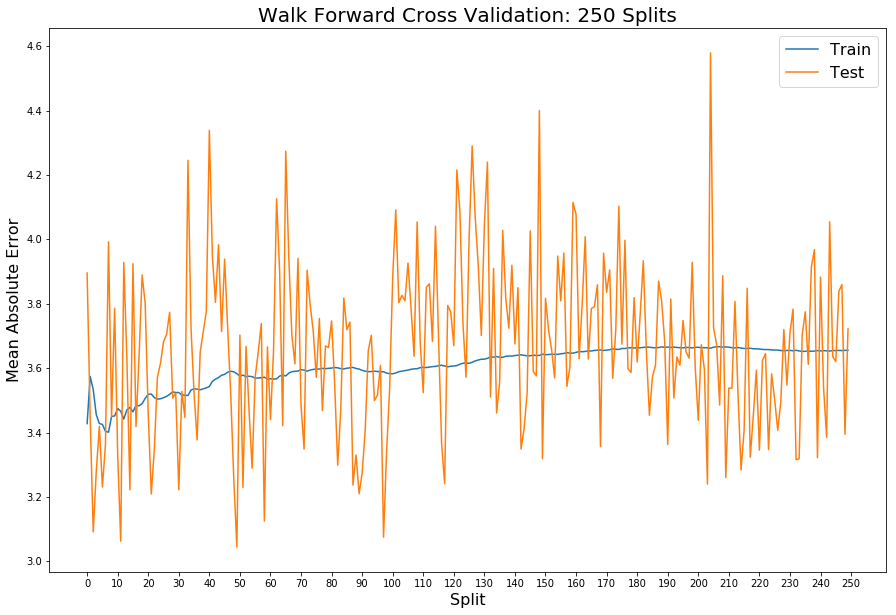

In [234]:
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(y=train_mae, x=np.arange(0, len(train_mae)))
ax = sns.lineplot(y=test_mae, x=np.arange(0, len(test_mae)), ax=ax, legend='brief')
ax.set_xticks(ticks=np.arange(0,len(test_mae)+1, 10))
ax.set_xlabel(xlabel="Split", fontsize=16)
ax.set_ylabel(ylabel="Mean Absolute Error", fontsize=16)
ax.set_title("Walk Forward Cross Validation: {} Splits".format(len(train_mae)), fontsize=20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
ax.legend(labels=['Train','Test'], fontsize=16)
plt.show()

In [218]:
print(np.mean(train_mae))
print(np.mean(test_mae))

3.6063307687835096
3.66328887921169


Actually train the model

In [213]:
batting_cv = baseball_models.CrossValidator()

#make sure we are sorted by time (days)
bat_feature_df_sub.sort_values(by='roto_game_id',inplace=True)

X_bat, y_bat, tscv_bat = batting_cv.train_test_split(bat_feature_df_sub.drop('fd_score', axis=1), bat_feature_df_sub['fd_score'], num_splits=250)

#y_bat.fillna(0, inplace=True)

#remove features that we know aren't valuable from previous feature engineering
#we can add new features that we are trying for the first time in the 'new_features parameter'

#life_features = bat_life_avgs.drop('roto_game_id', axis=1).columns
#matchup_features = bat_start_pitcher_matchups.drop('roto_game_id', axis = 1).columns
#bat_roto_features = bat_rotoguru.drop('roto_game_id', axis = 1).columns

#new_columns = list(life_features)+list(matchup_features)+list(bat_roto_features)

#new_columns.append('lagged_fd_score')

#add other new features as a list here...

#X_bat = batting_cv.clean_for_model(X_bat, batting=True, new_features = new_columns)

#initialize the model
xgbreg_bat = xgboost.XGBRegressor(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8, 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

#batting_cv.cross_validate(X_bat, y_bat, tscv_bat, xgbreg_bat)

C:\Users\Chris\Anaconda3\envs\data-sci\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
batting_cv.log_model(notes="250 iterations - just lagged_fd_score and home/away")

In [229]:
import pickle

pickle.dump(xgbreg_bat, open("xgb_bat.pickle", 'wb'))
pickle.dump(batting_cv, open("batting_cv.pickle", 'wb'))

#pickle.dump(xgbreg_pitch, open("xgb_pitch.pickle", 'wb'))
#pickle.dump(pitching_cv, open("pitching_cv.pickle", 'wb'))

<h4> Make predictions! </h4>

In [25]:
#this lookup key table is needed to sync up to rotoguru data to make the final predictions
player_lookup = pd.read_csv("CSV/player_lookup_2015.csv")

We need to bring in Rotoguru data to get salary information

In [37]:
rotoguru  = pd.read_csv('mlb-dbd-2015.csv', sep=":", index_col=False)
rotoguru.columns = ['GID', 'MLB_ID','Name_Last_First','Name_First_Last',' P/H','Hand','Date','Team','Oppt','H/A','Game#','Game_ID','Gametime_ET','Team_score','Oppt_score','Home_Ump','Temp','Condition','W_speed','W_dir','ADI','prior_ADI','GS','GP','Pos','Order','Oppt_pitch_hand','Oppt_pich_GID','Oppt_pitch_MLB_ID','Oppt_pitch_Name','PA','wOBA_num','IP','W/L/S','QS','FD_points','DK_points','DD_points','SF_points','FD_salary','DK_salary','DD_salary','SF_salary','FD_pos','DK_pos','DD_pos','SF_pos']
rotoguru.drop(rotoguru.tail(1).index,inplace=True)
pd.set_option('display.max_columns', 500)
#get dates as normal formats
rotoguru['Date'] = rotoguru['Date'].astype(str).str[:-2]
rotoguru['Date'] = pd.to_datetime(rotoguru['Date'])
rotoguru['last_name'], rotoguru['first_name'] = zip(*rotoguru['Name_Last_First'].apply(lambda x: x.split(',')))

Combine Rotoguru data with batting data

In [101]:
#we zip up the game id and the prediction - lets get those into a dataframe and then we can join back in other info
bat_pred_df = pd.DataFrame(batting_cv.id_preds, columns=['fd_score', 'game_id'])

#join in other relevant columns
bat_pred_df = pd.merge(bat_pred_df, batting_df[['game_id', 'player', 'game_date']], on ='game_id')
bat_pred_df = pd.merge(bat_pred_df, player_lookup[['key_bbref', 'key_mlbam']], left_on='player', right_on='key_bbref')
#convert to datetime to be able to merge with rotoguru
bat_pred_df['game_date'] = pd.to_datetime(bat_pred_df['game_date'])
bat_pred_df.drop('player', axis=1, inplace=True)

bat_pred_df = pd.merge(bat_pred_df, rotoguru[['MLB_ID', 'first_name', 'last_name', 'Date', 'Team', 'Pos', 'FD_points', 'FD_salary']], left_on=['game_date', 'key_mlbam'],
        right_on=['Date', 'MLB_ID'])

#drop extraneous columns
bat_pred_df.drop(['MLB_ID', 'Date'], axis=1, inplace=True)
#there are a couple rows that don't show up in the rotoguru data
bat_pred_df.dropna(inplace=True)

Do the same for the pitching dataframe

In [100]:
pitch_pred_df = pd.DataFrame(pitching_cv.id_preds, columns=['fd_score', 'game_id'])

#join in other relevant columns
pitch_pred_df = pd.merge(pitch_pred_df, pitching_df[['game_id', 'player', 'game_date']], on ='game_id')
pitch_pred_df = pd.merge(pitch_pred_df, player_lookup[['key_bbref', 'key_mlbam']], left_on='player', right_on='key_bbref')
#convert to datetime to be able to merge with rotoguru
pitch_pred_df['game_date'] = pd.to_datetime(pitch_pred_df['game_date'])
pitch_pred_df.drop('player', axis=1, inplace=True)

pitch_pred_df = pd.merge(pitch_pred_df, rotoguru[['MLB_ID', 'first_name', 'last_name', 'Date', 'Team', 'Pos', 'FD_points', 'FD_salary']], left_on=['game_date', 'key_mlbam'],
        right_on=['Date', 'MLB_ID'])

#drop extraneous columns
pitch_pred_df.drop(['MLB_ID', 'Date'], axis=1, inplace=True)
#there are a couple rows that don't show up in the rotoguru data
pitch_pred_df.dropna(inplace=True)

Merge the two together to hand to the optimizer

In [102]:
prediction_df = pd.concat([bat_pred_df, pitch_pred_df], axis=0)

#exclude postseason days
prediction_df = prediction_df[prediction_df['game_date'] < '2015-10-01']

We need to do some final cleaning of the positions to prepare for optimizing

In [103]:
prediction_df.loc[(prediction_df['Pos'] == 'C') | (prediction_df['Pos'] == '1B'), 'Pos'] = '1B/C'
prediction_df.loc[(prediction_df['Pos'] == 'CF') | (prediction_df['Pos'] == 'LF') | (prediction_df['Pos'] == 'RF'), 'Pos'] = 'OF'
prediction_df.loc[prediction_df['Pos'] == 'DH', 'Pos'] = 'UTIL'

<h3> OPTIMIZZZEEE </h3>

In [50]:
import pandas as pd
from pydfs_lineup_optimizer import get_optimizer, Site, Sport, Player

optimizer = get_optimizer(Site.FANDUEL, Sport.BASEBALL)

In [178]:
#select a random day to test - we will want to be more methodical and test a series of days going forward I think
unique_test_days = prediction_df['game_date'].astype(str).unique()
rand_day = unique_test_days[np.random.randint(0, len(unique_test_days))]

#need to add

day_to_predict_df = prediction_df[prediction_df['game_date'] == rand_day]

In [179]:
print("We are predicting lineups for: ", rand_day)

We are predicting lineups for:  2015-09-15


In [180]:
print("There are {} players to select a lineup from".format(day_to_predict_df.shape[0]))

There are 309 players to select a lineup from


Let's create the list of player objects to hand to the optimizer

In [181]:
players = list(day_to_predict_df.apply(get_player_object, axis=1))

<h3> THE PREDICTED LINEUP </h3>

AKA holy shit it works

In [182]:
optimizer.load_players(players)
predicted_best_lineup = next(optimizer.optimize(n=1))

print(predicted_best_lineup)
print(predicted_best_lineup.players)  # list of players
print(predicted_best_lineup.fantasy_points_projection)
print(predicted_best_lineup.salary_costs)

 1. P      Jacob deGrom                 P     NYM            24.128  11100.0$  
 2. C/1B   Dan Murphy                   2B/1B NYM            6.08    3400.0$   
 3. 2B     Brian Dozier                 2B    MIN            6.865   3000.0$   
 4. 3B     Nolan Arenado                3B    COL            7.554   4000.0$   
 5. SS     Alexei Ramirez               SS/P  CHW            7.954   3300.0$   
 6. OF     Yoenis Cespedes              OF    NYM            7.564   5100.0$   
 7. OF     Jose Bautista                OF    TOR            8.164   5400.0$   
 8. OF     Bryce Harper                 OF    WAS            7.972   5300.0$   
 9. UTIL   Josh Donaldson               3B    TOR            7.405   5700.0$   

Fantasy Points 83.69
Salary 46300.00

[ Jacob deGrom P (NYM),  Dan Murphy 2B/1B (NYM),  Brian Dozier 2B (MIN),  Nolan Arenado 3B (COL),  Alexei Ramirez SS/P (CHW),  Yoenis Cespedes OF (NYM),  Jose Bautista OF (TOR),  Bryce Harper OF (WAS),  Josh Donaldson 3B (TOR)]
83.687
46300.

Let's see how these players actually performed on the day we picked!

In [183]:
rotoguru_rand_day = rotoguru[rotoguru['Date'] == rand_day]

In [184]:
players = []
for player in predicted_best_lineup.players:
    player_list = str(player).split(" ")
    first_name = player_list[1]
    last_name = player_list[2]
    
    players.append(last_name + ", " + first_name)
    
actual_team_performance = rotoguru_rand_day[rotoguru_rand_day['Name_Last_First'].isin(players)]

In [185]:
actual_team_performance[['Name_Last_First', 'FD_points']]

,Name_Last_First,FD_points
1438,"Arenado, Nolan",8.00
2380,"Bautista, Jose",-1.00
7823,"Cespedes, Yoenis",0.00
10503,"deGrom, Jacob",4.00
11277,"Donaldson, Josh",-1.00
11449,"Dozier, Brian",1.00
19097,"Harper, Bryce",16.00
29653,"Murphy, Dan",-1.25
35211,"Ramirez, Alexei",8.50


In [186]:
actual_team_performance['FD_points'].sum()

34.25

Now we want to re-run this and see what the actual best lineup was!

In [45]:
rotoguru = rotoguru[rotoguru['Date'] < '2015-09-15']

rotoguru.loc[(rotoguru['Pos'] == 'C') | (rotoguru['Pos'] == '1B'), 'Pos'] = '1B/C'
rotoguru.loc[(rotoguru['Pos'] == 'CF') | (rotoguru['Pos'] == 'LF') | (rotoguru['Pos'] == 'RF'), 'Pos'] = 'OF'
rotoguru.loc[rotoguru['Pos'] == 'DH', 'Pos'] = 'UTIL'

In [65]:
dates = list(rotoguru.Date.unique())

second_base = []

for date in dates[0:1]:
    real_players = list(rotoguru[rotoguru.Date == date].apply(get_player_object_real, axis=1))
    optimizer.load_players(real_players)

    for lineup in optimizer.optimize(n=1):
        second_base.append(lineup.players[2])

PulpSolverError: Pulp: Error while executing C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\pulp\solverdir\cbc\win\64\cbc.exe

In [62]:
second_base

[ Jonathan Schoop 2B (BAL),  Phillip Gosselin 2B (ARI),  Stephen Drew 2B (NYY)]

In [57]:
p[2]

 Jonathan Schoop 2B (BAL)

In [187]:
rotoguru_rand_day = rotoguru[rotoguru['Date'] == rand_day]

rotoguru_rand_day.loc[(rotoguru_rand_day['Pos'] == 'C') | (rotoguru_rand_day['Pos'] == '1B'), 'Pos'] = '1B/C'
rotoguru_rand_day.loc[(rotoguru_rand_day['Pos'] == 'CF') | (rotoguru_rand_day['Pos'] == 'LF') | (rotoguru_rand_day['Pos'] == 'RF'), 'Pos'] = 'OF'
rotoguru_rand_day.loc[rotoguru_rand_day['Pos'] == 'DH', 'Pos'] = 'UTIL'

real_players = list(rotoguru_rand_day.apply(get_player_object_real, axis=1))

optimizer.load_players(real_players)
for lineup in optimizer.optimize(n=1):
    print(lineup)
    print(lineup.players)  # list of players
    print(lineup.fantasy_points_projection)
    print(lineup.salary_costs)

C:\Users\Chris\Anaconda3\envs\si671\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


 1. P      Stephen Strasburg            P     WAS            26.0    10100.0$  
 2. C/1B   Mike Olt                     3B/1B CHW            0.25    2200.0$   
 3. 2B     Dee Gordon                   2B    MIA            10.75   3600.0$   
 4. 3B     Manny Machado                3B    BAL            8.25    3500.0$   
 5. SS     Marcus Semien                SS    OAK            9.5     2900.0$   
 6. OF     Bryce Harper                 OF    WAS            16.0    5300.0$   
 7. OF     Jason Heyward                OF    STL            14.75   3200.0$   
 8. OF     A.J. Pollock                 OF    ARI            10.25   3700.0$   
 9. UTIL   Josh Reddick                 OF    OAK            12.5    2400.0$   

Fantasy Points 108.25
Salary 36900.00

[ Stephen Strasburg P (WAS),  Mike Olt 3B/1B (CHW),  Dee Gordon 2B (MIA),  Manny Machado 3B (BAL),  Marcus Semien SS (OAK),  Bryce Harper OF (WAS),  Jason Heyward OF (STL),  A.J. Pollock OF (ARI),  Josh Reddick OF (OAK)]
108.25
36900.0


This function will be used to create a pydfs Player object from every row of the prediction database

In [46]:
def get_player_object(row):
    #get the positions
    pos_list = []
    for pos in row['Pos'].split('-'):
        pos_list.append(pos)
        
    p = Player(player_id = row['key_mlbam'], first_name = row['first_name'], last_name=row['last_name'], positions = pos_list,
              team=row['Team'], salary=row['FD_salary'], fppg=row['fd_score'])
    
    return p

def get_player_object_real(row):
    #get the positions
    pos_list = []
    for pos in row['Pos'].split('-'):
        pos_list.append(pos)
        
    p = Player(player_id = row['MLB_ID'], first_name = row['first_name'], last_name=row['last_name'], positions = pos_list,
              team=row['Team'], salary=row['FD_salary'], fppg=row['FD_points'])
    
    return p